# <center><font color=purple> Reinforcement Learning : Assigment 1 
### <center> Léonard Hussenot

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## <font color=green> I] Dynamic Programming

### Q1) defining the model


 A representation of the MDP in matrix form $MDP(S, A_s, P, R, \gamma)$ where
 - $S$ is the number of states
 - $A_s$ contains the list of action indices available in each state, i.e.,
    $A_s[state]$ is a list representing the index of actions available in such state
 - $P$ the transition matrix of dimension $S * \max{|A_s|} * S$
 - $R$ the reward matrix of dimension $S * \max{|A_s|}$

In [4]:
gamma = 0.95
S = 3

A_s = [[0,1],[0,1],[0,1]]

P_s0_a0 = [0.45,0,0.55]
P_s0_a1 = [0,0,1]
P0 = np.matrix([P_s0_a0, P_s0_a1])

P_s1_a0 = [0,0,1]
P_s1_a1 = [0.5,0.4,0.1]
P1 = np.matrix([P_s1_a0, P_s1_a1])

P_s2_a0 = [0.6,0,0.4]
P_s2_a1 = [0,0.9,0.1]
P2 = np.matrix([P_s2_a0, P_s2_a1])

P = np.array([P0,P1,P2])

In [5]:
R = np.array([
        [-0.4,0],
        [2,0],
        [-1,-.5]
    ])

## Q2) Value iteration

In [6]:
# direclty compute the optimal bellman operator

def optimal_bellman_operator(W, gamma = 0.95):
    mat = R[:,:] + gamma * np.dot(P[:,:,:], W)
    return np.max(mat, axis=1)

In [7]:
# Use d* to find the optimal value function in order to compute error

d_star = [1,0,1]
r_star = [R[i,d_star[i]] for i in range(3)]
P_star = np.array([P[i, d_star[i],:] for i in range(3)])
V_star = np.dot(np.linalg.inv(np.eye(3)-gamma*P_star), r_star)

In [8]:
V_star

array([ 12.393531 ,  14.393531 ,  13.0458221])

### <font color=purple>Value iteration

In [48]:
max_iter = 100
precision = 0.01
n_iter = 0
V0 = [22,0.31,-13]
V = V0
errors = []
keep_going = True
while n_iter < max_iter and keep_going:
    new_V = optimal_bellman_operator(V)
    error = np.max(np.abs(new_V-V_star))
    errors.append(error)
    if np.max(np.abs(new_V-V)) < precision:
        keep_going = False
    V = new_V
    n_iter +=1

In [49]:
print("----")
print("Reached iteration {}, final error : {}".format(n_iter, error))
print("Final value function found : {}".format(V))
print("----")

----
Reached iteration 68, final error : 0.1862887320619535
Final value function found : [ 12.20724227  14.20724227  12.85957167]
----


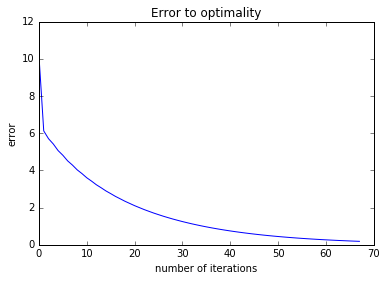

In [50]:
plt.plot(range(len(errors)),errors)
plt.xlabel("number of iterations")
plt.ylabel("error")
plt.title('Error to optimality')
plt.show()

#### (Optional) deduce the optimal policy from V*

In [12]:
mat = R[:,:] + gamma * np.dot(P[:,:,:], V)
optimal_policy_found = np.argmax(mat, axis=1)

In [13]:
print("optimal policy found is {}".format(optimal_policy_found))

optimal policy found is [1 0 1]


## Q3) Policy iteration

###  <font color=purple>Policy Iteration:

In [14]:
#initial policy
p0 = np.array([0,0,0])
p = p0

max_iter = 100
n_iter = 0
keep_going = True
V_pi= [0,0,0]

while n_iter < max_iter and (keep_going):
    # Policy evaluation
    r_pi = [R[i,p[i]] for i in range(3)]
    P_pi = np.array([P[i, p[i],:] for i in range(3)])
    new_V_pi = np.dot(np.linalg.inv(np.eye(3)-gamma*P_pi), r_pi)
    
    #stopping test
    keep_going = (np.max(np.abs(new_V_pi-V_pi))) != 0
    V_pi = new_V_pi
    
    
    # Policy improvement
    mat = R[:,:] + gamma * np.dot(P[:,:,:], new_V_pi)
    p = np.argmax(mat, axis=1)
    
    n_iter +=1

In [15]:
V_pi

array([ 12.393531 ,  14.393531 ,  13.0458221])

In [16]:
print("optimal policy {} found in {} iterations".format(p, n_iter))

optimal policy [1 0 1] found in 3 iterations


In [17]:
# Only 3 iterations !

The second method appear to converge in very few iterations (3 compare to more than 60 for the first method) and this is a great advantage.
Nonetheless, for each iteration we have to inverse a matrix (or at least to solve a linear system), operation that can be very time consuming.


## <font color=green>II] Reinforcement Learning

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
from gridworld import *
from gridrender import *
import time

### Policy Evaluation (First-visit Monte-Carlo)

In [19]:
# I directly computed V as J does not depend on Q

In [44]:
env = GridWorld1
policy = [0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3] #going right if possible, else up
gamma = 0.95
v_q4 = np.array([0.87691855, 0.92820033, 0.98817903, 0.00000000, 0.67106071, -0.99447514,
                 0.00000000, -0.82847001, -0.87691855,-0.93358351, -0.99447514])


n_simulation = 1500

# reasonable T_max for not being reached too many times (with a totally deterministic policy, we would be sure
# to reach a termination state within 4 move, but as we have a 10 percent chance of not following our decision,
# we need to have a higher T_max in order to prevent us to reach T_max too many times.
T_max = 15


jjs = []

sum_of_rewards = {}
for i in range(n_simulation):
    term = False
    x_0 = env.reset()
    state = x_0
    if x_0 not in sum_of_rewards:
        sum_of_rewards[x_0] = []
    t = 0
    discounted_rewards = []
    while (not term) and t < T_max:

        action = policy[state]
        state, reward, term = env.step(state,action)
        discounted_rewards.append((gamma**t)*reward)
        if t == T_max-1:
            print("Tmax")
        t += 1
    sum_of_rewards[x_0].append(np.sum(discounted_rewards))
    
    a = {}
    for s in list(sum_of_rewards.keys()):
        a[s] = np.mean(sum_of_rewards[s])

    if len(a) < 11 : #check if all state have been to begining of a similation
        #print("need more trajectory simulation")
        pass

    V_n = []
    for i in range(11):
        if i in sum_of_rewards:
            V_n.append(a[i])
        else:
            V_n.append(0)
    V_n = np.array(V_n)

    jj = (1/11)*np.sum(V_n - v_q4)
    jjs.append(jj)

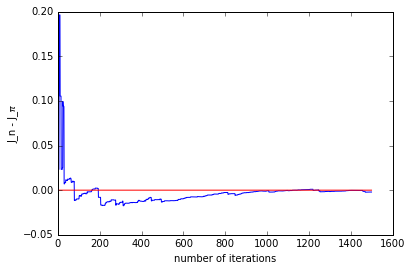

In [45]:
plt.plot(range(0,n_simulation), jjs)
plt.plot(range(0,n_simulation), [0]*n_simulation, color ="red")
plt.xlabel('number of iterations')
plt.ylabel('J_n - J_π')
plt.show()

## Policy optimization

* $T_{max}$ is chosen w.r.t to the rule of thumb described in the homework.
* $1 - \alpha$ corresponds to the confidence we have in the past. We thus choose $\alpha_i(x,a) = \frac{1}{1+N_i(x,a)} $ for it to be defined even when $N_i=0$

As we have a finite number of state, $N_i(x,a) \sim i$, as long as  $\mu_0(x)>0$ for all x. We thus have that $\sum{\alpha_i} = + \infty$ and $\sum{\alpha_i^2}<+\infty$

In [34]:
#Explain choice of T_max and alpha!
gamma = 0.95
delta = 0.1
Rmax = 1

T_max = int(-np.log(delta/Rmax)/(1-gamma))

In [35]:
env = GridWorld1

epsilon = 0.5

v_star = np.array([0.877, 0.928, 0.988, 0, 0.824, 0.928, 0, 0.778, 0.824, 0.877, 0.828])

n_states = 11
n_actions = 4

Q = np.zeros((n_states,n_actions))
N = np.zeros((n_states,n_actions))

max_iter = 10000
n_iter = 0
cumulutated_rewards = np.zeros(max_iter)
errors = []

while n_iter < max_iter:
    x_0 = env.reset()
    state = x_0
    t = 0
    term = False
    while t < T_max and (not term):
        t+=1
        #choose an action
        rdn = np.random.uniform()
        if rdn > epsilon :
            action = env.state_actions[state][np.argmax(Q[state,env.state_actions[state]])]
        else:
            action = np.random.choice(env.state_actions[state])
            
        N[state,action] +=1
        alpha = 1/(1+ N[state,action]) 
        new_state, reward, term = env.step(state,action)
        cumulutated_rewards[n_iter] += (gamma**t)*reward

        Q[state,action] = (1-alpha)*Q[state,action] + alpha*(reward + gamma*np.max(Q[new_state,:]))
        state = new_state
        
    n_iter+=1
    greedy_policy = np.argmax(Q,1)
    greedy_v = np.max(Q,1)
    errors.append(np.max(np.abs(v_star-greedy_v)))

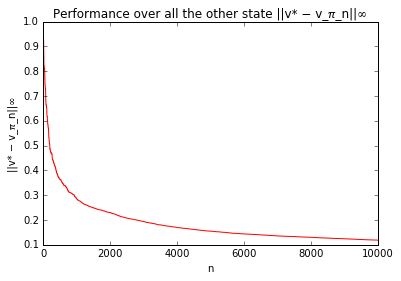

In [36]:
plt.plot(range(len(errors)),errors, color="r")
plt.title("Performance over all the other state ||v* − v_π_n||∞")
plt.xlabel("n")
plt.ylabel('||v* − v_π_n||∞')
plt.show()

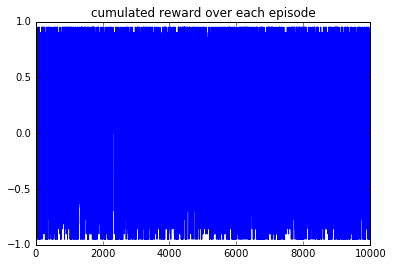

In [37]:
plt.plot(range(len(cumulutated_rewards)),cumulutated_rewards, color="b")
plt.title('cumulated reward over each episode')
plt.show()

As it is not really readable, we plot the cumulated untils the nth episode

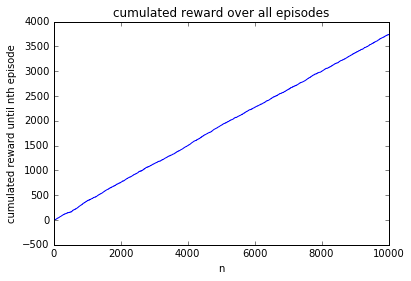

In [41]:
plt.plot(range(len(cumulutated_rewards)),np.cumsum(cumulutated_rewards), color="b")
plt.title('cumulated reward over all episodes')
plt.xlabel('n')
plt.ylabel('cumulated reward until nth episode')
plt.show()

In [42]:
def rapport_pos_neg(cumulutated_rewards):
    n_pos = 0
    n_neg = 0
    res = []
    for i in range(len(cumulutated_rewards)):
        if cumulutated_rewards[i]>=0:
            n_pos += 1
        else:
            n_neg += 1
        if n_neg ==0:
            res.append(0)
        else:
            res.append(n_pos/(n_neg+n_pos))
        
    return res

We here plot the proportion of positive reward received until episode n

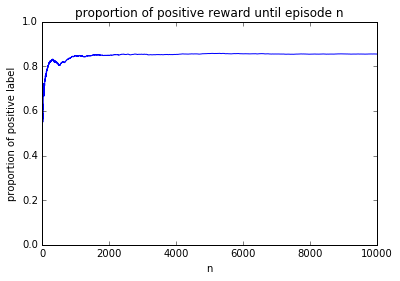

In [43]:
l =rapport_pos_neg(cumulutated_rewards)
plt.plot(range(len(l)),l)
plt.title('proportion of positive reward until episode n')
plt.xlabel('n')
plt.ylabel('proportion of positive label')
plt.ylim(0,1)
plt.show()

We could have expected this proportion to tend to 1, but this figure enlights the trade-off
we make between explotation and exploration. The negative reward we keep receiving after convergence are 
due the exploration!

## Q6) Initial distribution

As long as initial distribution has a positive mass on each state, the optimal policy won't be changed. In fact, in our algorithm, as $Q_n$ converges to $Q*$ independantly of $\mu_0$, so $\pi_n$ is going to converge to $\pi*$.